# Synthetic dataset creation

In this notebook I create a synthetic dataset to test the proposed bandit algorithm and compare it to benchmarks.
Synthetic dataset will have following features:
- 10,000 time points
- At each time $t$ the environment generates a context vector $x_t$ of dimension 6. Each feature $x_t^{(i)}$ is **categorical**, and lies in range(1,feature_size). This is needed for the `state_extract` function in SimOOS to correctly number all the states.
- Each context vector $x_t$ is associated with a cost vector $c_t$. Cost of each feature $c_t^{i}$ follows a Gaussian distribution with fixed standard deviation and **piecewise-constant** mean lying in range $[0; 0.02]$. Change-points of costs are different from change points of rewards.
- A fixed (for all $t$) set $\mathcal{A}$ of 5 arms are available for the algorithm to choose from.
- Rewards associated with each arm and context follow a Bernoulli distribution, parametrized by $p$. For each arm $a_i$, parameter $p$ is piecewise-constant and thus the corresponding **generating process of rewards is piecewise-stationary** with change points on steps 500, 1000, 2000, 5000, 8000.



In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [4]:
TIME_POINTS = 10000
NUM_FEATURES = 5
N_ARMS = 5

## Creating context vectors

In [5]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [6]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [7]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1, 2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1, 2, 3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [8]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [9]:
contexts, contexts.shape

(array([[4., 2., 2., 4., 4.],
        [4., 2., 1., 3., 4.],
        [4., 1., 1., 3., 5.],
        ...,
        [2., 2., 1., 4., 2.],
        [1., 2., 1., 4., 3.],
        [2., 2., 1., 4., 5.]]),
 (10000, 5))

### Visualizing context features

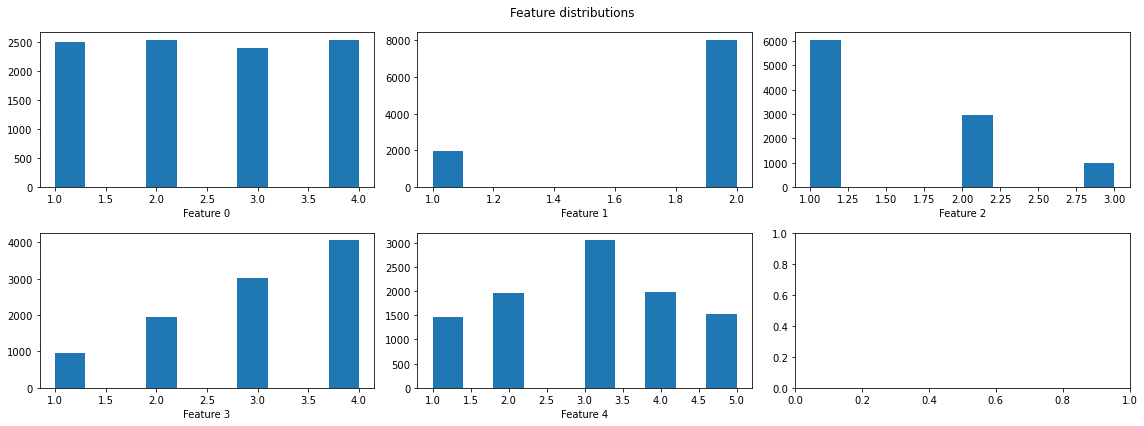

In [10]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [11]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0, 0.09, size=(NUM_FEATURES,)) for i in range(5)]

In [12]:
interval_means

[array([0.03853182, 0.04585677, 0.05224262, 0.05280608, 0.03599646]),
 array([0.01496068, 0.02262432, 0.03711671, 0.0557764 , 0.04090554]),
 array([0.07124732, 0.05175519, 0.03084086, 0.04474216, 0.03234015]),
 array([0.00272997, 0.02529622, 0.04057936, 0.02297588, 0.06476056]),
 array([0.07759044, 0.02672544, 0.0021796 , 0.07879811, 0.05196527])]

In [13]:
# Fixed std
interval_stds = [[0.001]*NUM_FEATURES]*5

In [14]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

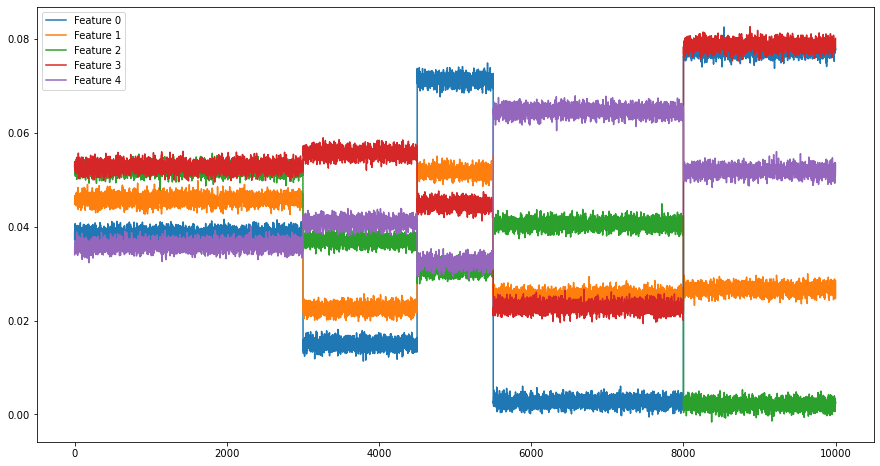

In [15]:
plot_costs(get_costs(), 10000)

In [16]:
costs_obj = get_costs()

In [17]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [18]:
costs_vector.shape

(10000, 5)

## Creating rewards

In [19]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [20]:
slices = [
    slice(0,500),
    slice(500,1000),
    slice(1000,2000),
    slice(2000,5000),
    slice(5000,8000),
    slice(8000,10000),
]

In [21]:
HIGH_REWARD_RANGE = [0.4, 0.99]
LOW_REWARD_RANGE = [0.01, 0.4]

In [22]:
# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

mean_rewards = np.zeros(rewards.shape)


for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    high_reward_arm = np.random.choice(N_ARMS)
    
    high_reward_arm = i % N_ARMS
    for arm in range(N_ARMS):

        # Use p from config (reward range is config)
        if arm == high_reward_arm:
            reward_range = HIGH_REWARD_RANGE
        else:
            reward_range = LOW_REWARD_RANGE
        
        p = np.random.uniform(reward_range[0], reward_range[1])

        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )
        
        # for visualization
        mean_rewards[interval_slice, arm] = np.ones(slice_rewards.shape) * np.mean(slice_rewards)

    

Slice 0:
  Arm 0: p=0.48, mean reward=0.49   reward estimated by linear regression 0.48
  Arm 1: p=0.22, mean reward=0.20   reward estimated by linear regression 0.20
  Arm 2: p=0.04, mean reward=0.05   reward estimated by linear regression 0.05
  Arm 3: p=0.35, mean reward=0.31   reward estimated by linear regression 0.30
  Arm 4: p=0.07, mean reward=0.06   reward estimated by linear regression 0.06
Slice 1:
  Arm 0: p=0.24, mean reward=0.26   reward estimated by linear regression 0.25
  Arm 1: p=0.55, mean reward=0.50   reward estimated by linear regression 0.48
  Arm 2: p=0.21, mean reward=0.20   reward estimated by linear regression 0.19
  Arm 3: p=0.27, mean reward=0.28   reward estimated by linear regression 0.27
  Arm 4: p=0.25, mean reward=0.24   reward estimated by linear regression 0.24
Slice 2:
  Arm 0: p=0.02, mean reward=0.02   reward estimated by linear regression 0.02
  Arm 1: p=0.10, mean reward=0.09   reward estimated by linear regression 0.09
  Arm 2: p=0.64, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_65398/492892621.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


### Visualising rewards

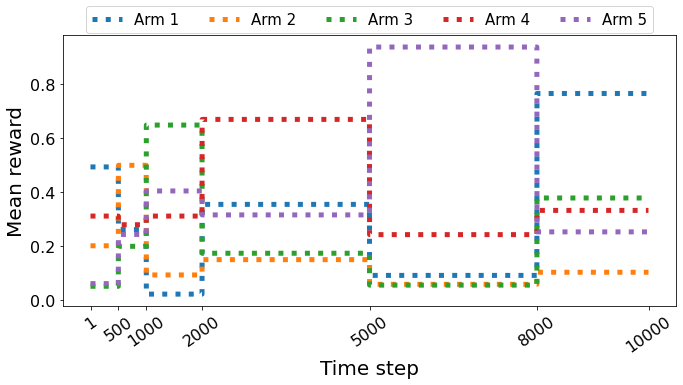

In [23]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000, 2000, 5000, 8000, 10000]
plt.xticks(extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel('Mean reward', fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [24]:
rewards.shape

(10000, 5)

In [25]:
costs_vector.shape

(10000, 5)

In [26]:
data = (contexts, rewards, costs_vector)

In [27]:
import pickle

with open('dataset/synthetic/synthetic_data.pickle', 'wb') as f:
    pickle.dump(data, f)

## Testing algorithms on synthetic data

In [28]:
%load_ext autoreload
%autoreload 2

import algorithms
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
NUM_OF_TRIALS = 10000

In [30]:
p_random = algorithms.RandomPolicy()
gain_random = evaluation.evaluate_on_synthetic_data(
    p_random,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Starting repetition 0:
Random policy
Total gain: 3117.0
	Total reward: 3117.0
	Total cost: 0
Execution time: 0.1s



In [31]:
egreedy = algorithms.EpsilonGreedy(epsilon=0.1, n_arms=rewards.shape[1])

gain_egreedy = evaluation.evaluate_on_synthetic_data(
    egreedy,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Starting repetition 0:
E-greedy(epsilon=0.1)
Total gain: 3964.0
	Total reward: 3964.0
	Total cost: 0
Execution time: 0.1s



In [32]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=0.45,
    )

gain_ucb = evaluation.evaluate_on_synthetic_data(
    ucb_alg,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Starting repetition 0:
UCB1 (α=0.45)
Total gain: 5412.0
	Total reward: 5412.0
	Total cost: 0
Execution time: 0.1s



In [33]:
linucb = algorithms.LinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=0.5,
)
gain_linucb = evaluation.evaluate_on_synthetic_data(
    linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Starting repetition 0:
LinUCB (alpha=0.5)
Total gain: 2018.3632865996046
	Total reward: 4048.0
	Total cost: 2029.636713400398
Execution time: 0.4s



In [34]:
ps_linucb = algorithms.PSLinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=0.7,
    omega=100,
    delta=0.03,
)


gain_pslinucb = evaluation.evaluate_on_synthetic_data(
    ps_linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
change_points = ps_linucb.change_points

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Total gain: 4965.363286599623
	Total reward: 6995.0
	Total cost: 2029.636713400398
Execution time: 0.4s



In [35]:
s = time.time()
p_simoos = algorithms.SimOOSAlgorithm(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=0.6,
    delta_SimOOS=0.2,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_simoos = evaluation.evaluate_on_synthetic_data(
        p_simoos,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Took 0.0028700828552246094 seconds
Starting repetition 0:
Trial 0, time 2022-04-08 20:13:35.999627
Trial 500, time 2022-04-08 20:14:44.489909
Trial 1000, time 2022-04-08 20:15:43.655805
Trial 1500, time 2022-04-08 20:16:27.423225
Trial 2000, time 2022-04-08 20:16:58.837976
Trial 2500, time 2022-04-08 20:17:27.735467
Trial 3000, time 2022-04-08 20:17:52.551208
Trial 3500, time 2022-04-08 20:18:16.601606
Trial 4000, time 2022-04-08 20:18:35.772668
Trial 4500, time 2022-04-08 20:18:49.841835
Trial 5000, time 2022-04-08 20:19:04.751698
Trial 5500, time 2022-04-08 20:19:16.732884
Trial 6000, time 2022-04-08 20:19:29.260155
Trial 6500, time 2022-04-08 20:19:40.167144
Trial 7000, time 2022-04-08 20:19:48.407973
Trial 7500, time 2022-04-08 20:19:55.325023
Trial 8000, time 2022-04-08 20:20:01.753211
Trial 8500, time 2022-04-08 20:20:07.735015
Trial 9000, time 2022-04-08 20:20:15.546288
Trial 9500, time 2022-04-08 20:20:23.357989
SimOOS (beta=0.6, delta=0.2)
Total gain: 1896.9680475414125
	Total

In [36]:
s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta=1.0,
    delta=0.12,
    window_length=2000,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Took 0.00475311279296875 seconds
Starting repetition 0:
Round 500, time 2022-04-08 20:24:42.049979
Round 1000, time 2022-04-08 20:39:30.030105
Round 1500, time 2022-04-08 21:04:54.663126
Round 2000, time 2022-04-08 21:44:12.311862
Round 2500, time 2022-04-08 22:35:11.101450
Round 3000, time 2022-04-08 23:26:20.937052
Round 3500, time 2022-04-09 00:19:04.250697
Round 4000, time 2022-04-09 01:11:38.367946
Round 4500, time 2022-04-09 02:04:32.302314
Round 5000, time 2022-04-09 02:57:38.274199
Round 5500, time 2022-04-09 03:50:27.854448
Round 6000, time 2022-04-09 04:43:10.648825
Round 6500, time 2022-04-09 05:35:56.462862
Round 7000, time 2022-04-09 06:28:32.847029
Round 7500, time 2022-04-09 07:21:01.799115
Round 8000, time 2022-04-09 08:13:49.123847
Round 8500, time 2022-04-09 09:06:34.768653
Round 9000, time 2022-04-09 09:59:14.203013
Round 9500, time 2022-04-09 10:51:29.644748
Algorithm1 (beta=1.0, delta=0.12, w=2000)
Total gain: 6854.400682011825
	Total reward: 6858.0
	Total cost: 3.

### Plot cumulative gain

In [37]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 500, 1000, 2000, 5000, 8000, 10000]
    plt.xticks( extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    
    plt.legend(prop={'size': 16});
    plt.savefig('gain_synthetic.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

    
    plt.show();

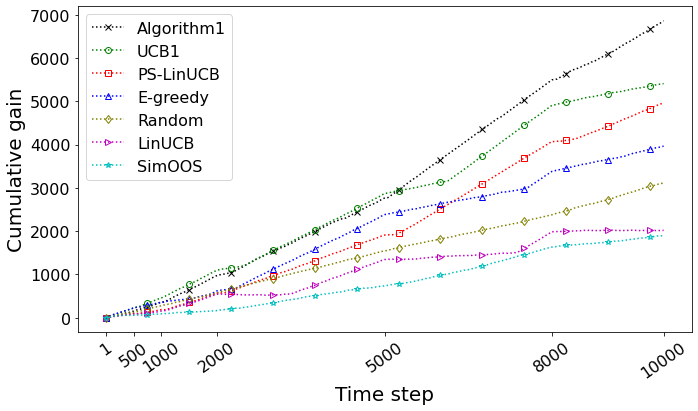

In [38]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)
